In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()
    !pip install --quiet git+https://github.com/BayraktarLab/cell2location#egg=cell2location[tutorials]

In [2]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import gzip
import pandas as pd
import anndata
import torch

import cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

/home/linxy29/anaconda3/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
cell2location.__version__

'0.1.4'

In [5]:
#folder = "/home/linxy29/data/spaceclone/cSCC/"
folder = "/home/linxy29/data/CIVET"
sample_name = "visium_breastcancer_10x"
results_folder = f'{folder}/{sample_name}/cSCC_cell2location/'
# create the results folder if it doesn't exist
import os
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{folder}/breastcancer_atlas/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

### Loading Visium and scRNA-seq reference data

In [6]:
# Path to the filtered feature barcode matrix
matrix_h5_path = f'{folder}/{sample_name}/CytAssist_FFPE_Protein_Expression_Human_Breast_Cancer_filtered_feature_bc_matrix.h5'
# Path to the spatial directory
spatial_dir = f'{folder}/{sample_name}'

# Load Visium data
adata_vis = sc.read_visium(path=spatial_dir, count_file=matrix_h5_path)

adata_vis.obs['sample'] = sample_name
## make the variable names unique
adata_vis.var_names_make_unique()
print(adata_vis)

/home/linxy29/anaconda3/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/linxy29/anaconda3/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4169 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'sample'
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'normalized', 'pattern', 'read', 'secondary_name', 'sequence'
    uns: 'spatial'
    obsm: 'spatial'


In [7]:
# find mitochondria-encoded (MT) genes
#adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var_names]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

In [8]:
# read reference file
adata_ref = sc.read_10x_mtx(f'{folder}/breastcancer_atlas/Allcells_raw_count_out/BrCa_Atlas_Count_out/')
adata_ref.var.head()

gene_ids    feature_types
RP11-34P13.7    RP11-34P13.7  Gene Expression
FO538757.3        FO538757.3  Gene Expression
FO538757.2        FO538757.2  Gene Expression
AP006222.2        AP006222.2  Gene Expression
RP4-669L17.10  RP4-669L17.10  Gene Expression

In [9]:
# read metadata 
metadata = pd.read_csv(f'{folder}/breastcancer_atlas/Whole_miniatlas_meta.csv', index_col=0)  # Use the first column (barcodes) as the index
# Ensure the metadata index matches the adata.obs index
metadata = metadata.loc[adata_ref.obs_names]  # Reorder metadata to match adata.obs
adata_ref.obs = metadata

/tmp/ipykernel_6926/6686812.py:2: DtypeWarning: Columns (2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f'{folder}/breastcancer_atlas/Whole_miniatlas_meta.csv', index_col=0)  # Use the first column (barcodes) as the index


In [10]:
adata_ref.obs['celltype_minor'] = adata_ref.obs['celltype_minor'].str.replace(' ', '_')  # Replace spaces with underscores
## check the metadata
adata_ref.obs.head()

Patient Percent_mito nCount_RNA nFeature_RNA  \
CID3586_AAGACCTCAGCATGAG  CID3586  1.506221349       4581         1689   
CID3586_AAGGTTCGTAGTACCT  CID3586  5.793742758       1726          779   
CID3586_ACCAGTAGTTGTGGCC  CID3586  1.383238405       1229          514   
CID3586_ACCCACTAGATGTCGG  CID3586  1.923076923       1352          609   
CID3586_ACTGATGGTCAACTGT  CID3586  13.32554062       1711          807   

                         celltype_major     celltype_minor    celltype_subset  \
CID3586_AAGACCTCAGCATGAG    Endothelial  Endothelial_ACKR1  Endothelial ACKR1   
CID3586_AAGGTTCGTAGTACCT    Endothelial  Endothelial_ACKR1  Endothelial ACKR1   
CID3586_ACCAGTAGTTGTGGCC    Endothelial  Endothelial_ACKR1  Endothelial ACKR1   
CID3586_ACCCACTAGATGTCGG    Endothelial  Endothelial_ACKR1  Endothelial ACKR1   
CID3586_ACTGATGGTCAACTGT    Endothelial  Endothelial_ACKR1  Endothelial ACKR1   

                         subtype     gene_module            Calls  \
CID3586_AAGACCTCAGCATGAG   HER2+  no_gene_module  no_scTYPER_call   
CID3586_AAGGTTCGTAGTACCT   HER2+  no_gene_module  no_scTYPER_call   
CID3586_ACCAGTAGTTGTGGCC   HER2+  no_gene_module  no_scTYPER_call   
CID3586_ACCCACTAGATGTCGG   HER2+  no_gene_module  no_scTYPER_call   
CID3586_ACTGATGGTCAACTGT   HER2+  no_gene_module  no_scTYPER_call   

                          normal_cell_call     CNA_value  
CID3586_AAGACCTCAGCATGAG  no_inferCNV_call  no_CNA_value  
CID3586_AAGGTTCGTAGTACCT  no_inferCNV_call  no_CNA_value  
CID3586_ACCAGTAGTTGTGGCC  no_inferCNV_call  no_CNA_value  
CID3586_ACCCACTAGATGTCGG  no_inferCNV_call  no_CNA_value  
CID3586_ACTGATGGTCAACTGT  no_inferCNV_call  no_CNA_value

In [11]:
adata_ref.var['SYMBOL'] = adata_ref.var_names
adata_ref.var.set_index('gene_ids', drop=True, inplace=True)

In [34]:
adata_ref.var.head()

feature_types      SYMBOL  n_cells  nonz_mean
gene_ids                                                   
FO538757.2  Gene Expression  FO538757.2    10398   1.199173
AP006222.2  Gene Expression  AP006222.2     4824   1.226783
SAMD11      Gene Expression      SAMD11     1133   1.202118
NOC2L       Gene Expression       NOC2L    19341   1.634766
PLEKHN1     Gene Expression     PLEKHN1     2398   1.127189

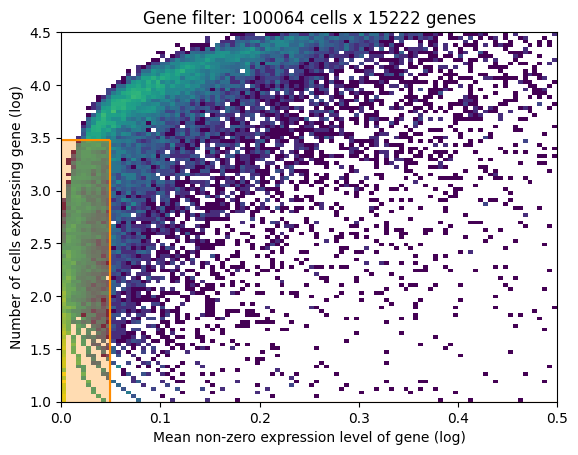

In [12]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

### Estimation of reference cell type signatures (NB regression)(No need to run!!!!!!!)

In [13]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='Patient',
                        # cell type, covariate used for constructing signatures
                        labels_key='celltype_minor'
                       )

/home/linxy29/anaconda3/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [14]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.2.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Patient',
│   'labels_key': 'celltype_minor',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   26   │
│         n_cells          │ 100064 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   29   │
│          n_vars          │ 15222  │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Patient'] │  CID3586   │          0          │
│                      │  CID3838   │          1          │
│                      │  CID3921   │          2          │
│                      │  CID3941   │          3          │
│                      │  CID3946   │          4          │
│                      │  CID3948   │          5          │
│                      │  CID3963   │          6          │
│                      │  CID4040   │          7          │
│                      │  CID4066   │          8          │
│                      │  CID4067   │          9          │
│                      │  CID4290A  │         10          │
│                      │  CID4398   │         11          │
│                      │  CID44041  │         12          │
│                      │  CID4461   │         13          │
│                      │  CID4463   │         14          │
│                      │  CID4465   │         15          │
│                      │  CID4471   │         16          │
│                      │  CID4495   │         17          │
│                      │  CID44971  │         18          │
│                      │  CID44991  │         19          │
│                      │  CID4513   │         20          │
│                      │  CID4515   │         21          │
│                      │  CID45171  │         22          │
│                      │  CID4523   │         23          │
│                      │  CID4530N  │         24          │
│                      │  CID4535   │         25          │
└──────────────────────┴────────────┴─────────────────────┘

                               labels State Registry                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location       ┃         Categories          ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['celltype_minor'] │       B_cells_Memory        │          0          │
│                             │        B_cells_Naive        │          1          │
│                             │     CAFs_MSC_iCAF-like      │          2          │
│                             │       CAFs_myCAF-like       │          3          │
│                             │       Cancer_Basal_SC       │          4          │
│                             │       Cancer_Cycling        │          5          │
│                             │       Cancer_Her2_SC        │          6          │
│                             │       Cancer_LumA_SC        │          7          │
│                             │       Cancer_LumB_SC        │          8          │
│                             │       Cycling_Myeloid       │          9          │
│                             │         Cycling_PVL         │         10          │
│                             │       Cycling_T-cells       │         11          │
│                             │             DCs             │         12          │
│                             │      Endothelial_ACKR1      │         13          │
│                             │     Endothelial_CXCL12      │         14          │
│                             │ Endothelial_Lymphatic_LYVE1 │         15          │
│                             │      Endothelial_RGS5       │         16          │
│                             │     Luminal_Progenitors     │         17          │
│                             │         Macrophage          │         18          │
│                             │       Mature_Luminal        │         19          │
│                             │          Monocyte           │         20          │
│                             │        Myoepithelial        │         21          │
│                             │          NKT_cells          │         22          │
│                             │          NK_cells           │         23          │
│                             │     PVL_Differentiated      │         24          │
│                             │        PVL_Immature         │         25          │
│                             │        Plasmablasts         │         26          │
│                             │        T_cells_CD4+         │         27          │
│                             │        T_cells_CD8+         │         28          │
└─────────────────────────────┴─────────────────────────────┴─────────────────────┘

In [15]:
mod.train(max_epochs=250)

/home/linxy29/anaconda3/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/linxy29/anaconda3/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/home/linxy29/anaconda3/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 250/250: 100%|██████████| 250/250 [7:24:51<00:00, 81.75s/it, v_num=1, elbo_train=5.77e+8]   

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [7:24:51<00:00, 106.77s/it, v_num=1, elbo_train=5.77e+8]


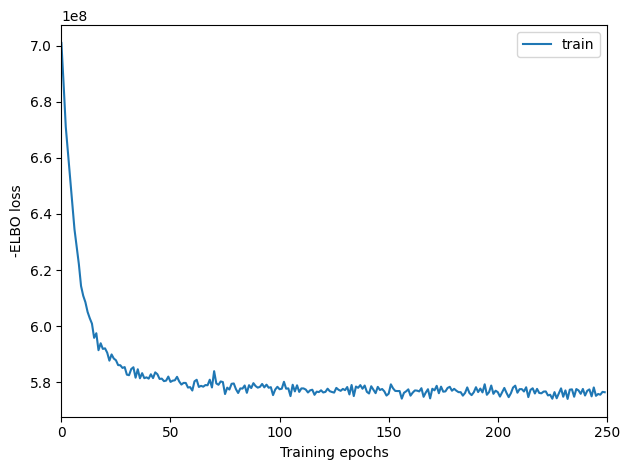

In [16]:
mod.plot_history()

In [18]:
# Save model
#mod.save(f"{run_name}", overwrite=True)
# Load model
mod = cell2location.models.RegressionModel.load(f"{run_name}", adata_ref)

INFO     File /home/linxy29/data/CIVET/visium_breastcancer_10x/cSCC_cell2location//cell2location_map/model.pt      
         already downloaded                                                                                        


/home/linxy29/anaconda3/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/linxy29/anaconda3/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/home/linxy29/anaconda3/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=

Epoch 1/200:   0%|          | 1/200 [00:04<13:25,  4.05s/it, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/200:   0%|          | 1/200 [00:04<13:40,  4.13s/it, v_num=1]


In [20]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Function to sanitize obs columns
def sanitize_obs_columns(adata):
    for col in adata.obs.columns:
        dtype = adata.obs[col].dtype
        print(f"Processing column: {col}, dtype: {dtype}")
        
        # Handle numeric columns
        if pd.api.types.is_numeric_dtype(dtype):
            print(f"Converting numeric column '{col}' to string.")
            adata.obs[col] = adata.obs[col].astype(str)
        
        # Handle categorical columns
        elif pd.api.types.is_categorical_dtype(dtype):
            print(f"Converting categorical column '{col}' to string.")
            adata.obs[col] = adata.obs[col].astype(str)
        
        # Handle object columns
        elif pd.api.types.is_object_dtype(dtype):
            print(f"Checking object column '{col}' for invalid entries.")
            # Replace non-string objects with string representation
            adata.obs[col] = adata.obs[col].apply(lambda x: str(x) if pd.notnull(x) else "Unknown")
        
        # Handle NaN values (if present)
        if adata.obs[col].isnull().any():
            print(f"Filling NaN values in column '{col}' with 'Unknown'.")
            adata.obs[col] = adata.obs[col].fillna("Unknown")
    
    print("All columns sanitized.")

# Apply the function
sanitize_obs_columns(adata_ref)

# Attempt to save the sanitized AnnData object
try:
    adata_file = f"{ref_run_name}/sc.h5ad"
    adata_ref.write(adata_file)
    print(f"Successfully saved AnnData object to {adata_file}.")
except Exception as e:
    print(f"Error during save operation: {e}")

Sampling global variables, sample: 100%|██████████| 999/999 [01:46<00:00,  9.37it/s]
Processing column: Patient, dtype: category
Converting categorical column 'Patient' to string.
Processing column: Percent_mito, dtype: object
Checking object column 'Percent_mito' for invalid entries.
Processing column: nCount_RNA, dtype: object
Checking object column 'nCount_RNA' for invalid entries.
Processing column: nFeature_RNA, dtype: object
Checking object column 'nFeature_RNA' for invalid entries.


/tmp/ipykernel_6926/2384214154.py:21: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(dtype):
/tmp/ipykernel_6926/2384214154.py:21: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(dtype):


Processing column: celltype_major, dtype: category
Converting categorical column 'celltype_major' to string.
Processing column: celltype_minor, dtype: category
Converting categorical column 'celltype_minor' to string.
Processing column: celltype_subset, dtype: category
Converting categorical column 'celltype_subset' to string.
Processing column: subtype, dtype: category
Converting categorical column 'subtype' to string.
Processing column: gene_module, dtype: category
Converting categorical column 'gene_module' to string.
Processing column: Calls, dtype: category
Converting categorical column 'Calls' to string.
Processing column: normal_cell_call, dtype: category
Converting categorical column 'normal_cell_call' to string.
Processing column: CNA_value, dtype: category
Converting categorical column 'CNA_value' to string.
Processing column: _indices, dtype: int64
Converting numeric column '_indices' to string.
Processing column: _scvi_batch, dtype: int8
Converting numeric column '_scvi_bat

/tmp/ipykernel_6926/2384214154.py:21: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(dtype):
/tmp/ipykernel_6926/2384214154.py:21: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(dtype):
/tmp/ipykernel_6926/2384214154.py:21: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(dtype):
/tmp/ipykernel_6926/2384214154.py:21: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(dtype):
/tmp/ipykernel_6926/2384214154.py:21: DeprecationWarning: is_cat

All columns sanitized.
Successfully saved AnnData object to /home/linxy29/data/CIVET/breastcancer_atlas/reference_signatures/sc.h5ad.


In [21]:
adata_ref = mod.export_posterior(
    adata_ref, use_quantiles=True,
    # choose quantiles
    add_to_varm=["q05","q50", "q95", "q0001"],
    sample_kwargs={'batch_size': 2500}
)

In [ ]:
mod.plot_QC()

### Read reference data

In [9]:
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

/home/linxy29/anaconda3/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


INFO     File /home/linxy29/data/CIVET/breastcancer_atlas/reference_signatures/model.pt already downloaded         


/home/linxy29/anaconda3/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/linxy29/anaconda3/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/home/linxy29/anaconda3/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=

Epoch 1/200:   0%|          | 1/200 [00:03<12:55,  3.90s/it, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/200:   0%|          | 1/200 [00:03<13:03,  3.94s/it, v_num=1]


In [10]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

B_cells_Memory  B_cells_Naive  CAFs_MSC_iCAF-like  \
gene_ids                                                        
FO538757.2        0.014346       0.013887            0.071684   
AP006222.2        0.004310       0.003472            0.030525   
SAMD11            0.000489       0.002020            0.065477   
NOC2L             0.069898       0.095185            0.111775   
PLEKHN1           0.000610       0.001888            0.002327   

            CAFs_myCAF-like  Cancer_Basal_SC  
gene_ids                                      
FO538757.2         0.113353         0.165284  
AP006222.2         0.106218         0.079425  
SAMD11             0.111726         0.003694  
NOC2L              0.192897         0.906236  
PLEKHN1            0.006052         0.082100

### Cell2location: spatial mapping

In [11]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

In [12]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=20,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=200
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.2.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 4169  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 12682 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                         batch State Registry                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃       Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ visium_breastcancer_10x │          0          │
└─────────────────────┴─────────────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [14]:
mod.train(max_epochs=30000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/linxy29/anaconda3/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/home/linxy29/anaconda3/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/linxy29/anaconda3/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 28130/30000:  94%|█████████▍| 28129/30000 [14:51:17<1:30:14,  2.89s/it, v_num=1, elbo_train=4.74e+7]

In [47]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
print(adata_file)
print(adata_vis)

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Sampling global variables, sample: 100%|██████████| 999/999 [00:24<00:00, 41.13it/s]
/home/linxy29/holab/linxy/maester/spaceclone/cSCC/cSCC_cell2location/P6_ST_vis_rep1/cell2location_map/sp.h5ad
AnnData object with n_obs × n_vars = 3719 × 12379
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'MT_gene'
    uns: 'spatial', '_scvi_uuid', '_scvi_manager_uuid', 'mod'
    obsm: 'spatial', 'MT', 'means_cell_abundance_w_sf', 'stds_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf'


### Visualising cell abundance in spatial coordinates

In [48]:
## calculate the cell number
celltype_counts = adata_ref.obs['level3_celltype'].value_counts()
## sort the cell types by the number of cells
celltype_counts = celltype_counts.sort_values(ascending=False)
celltype_counts
## select cell types that start with 'Tumor'
celltype_counts_sub1 = celltype_counts[celltype_counts.index.str.startswith('Tumor')]
## slect rest of the cell types
celltype_counts_sub2 = celltype_counts[~celltype_counts.index.str.startswith('Tumor')]
## combine the two subsets
celltype_counts = pd.concat([celltype_counts_sub1, celltype_counts_sub2])
celltype_counts
## remove CD1C
celltype_counts = celltype_counts.drop('CD1C')

#celltype = adata_ref.obs['level3_celltype'].unique()

In [49]:
celltype_counts.index[:8]

CategoricalIndex(['Tumor_KC_Diff', 'Tumor_KC_Basal', 'Tumor_KC_Cyc',
                  'Normal_KC_Diff', 'Keratinocyte', 'Normal_KC_Basal', 'LC',
                  'Pilosebaceous'],
                 categories=['ASDC', 'B Cell', 'CD1C', 'CD4_Exh', ..., 'Treg', 'Tumor_KC_Basal', 'Tumor_KC_Cyc', 'Tumor_KC_Diff'], ordered=False, dtype='category', name='level3_celltype')

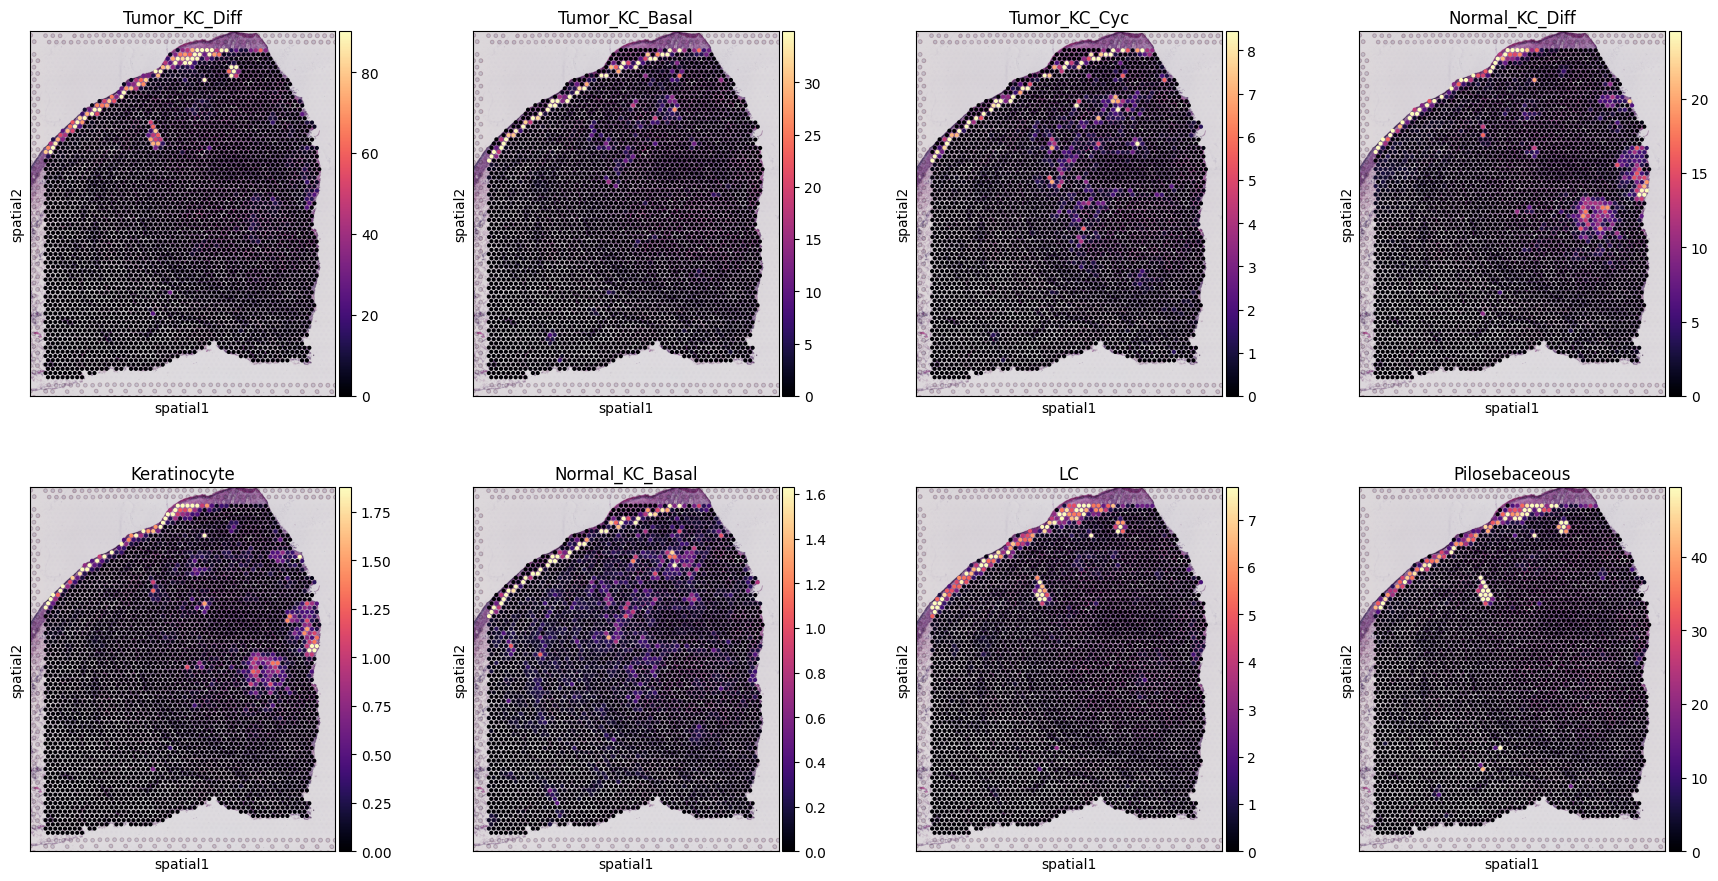

<Figure size 450x500 with 0 Axes>

In [50]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# select one slide
#from cell2location.utils import select_slide
#slide = select_slide(adata_vis, sample_name)
slide = adata_vis

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=celltype_counts.index[:8],
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )

    plt.savefig(f"{run_name}/cell_abundance_map_oneCellType.pdf", bbox_inches='tight')

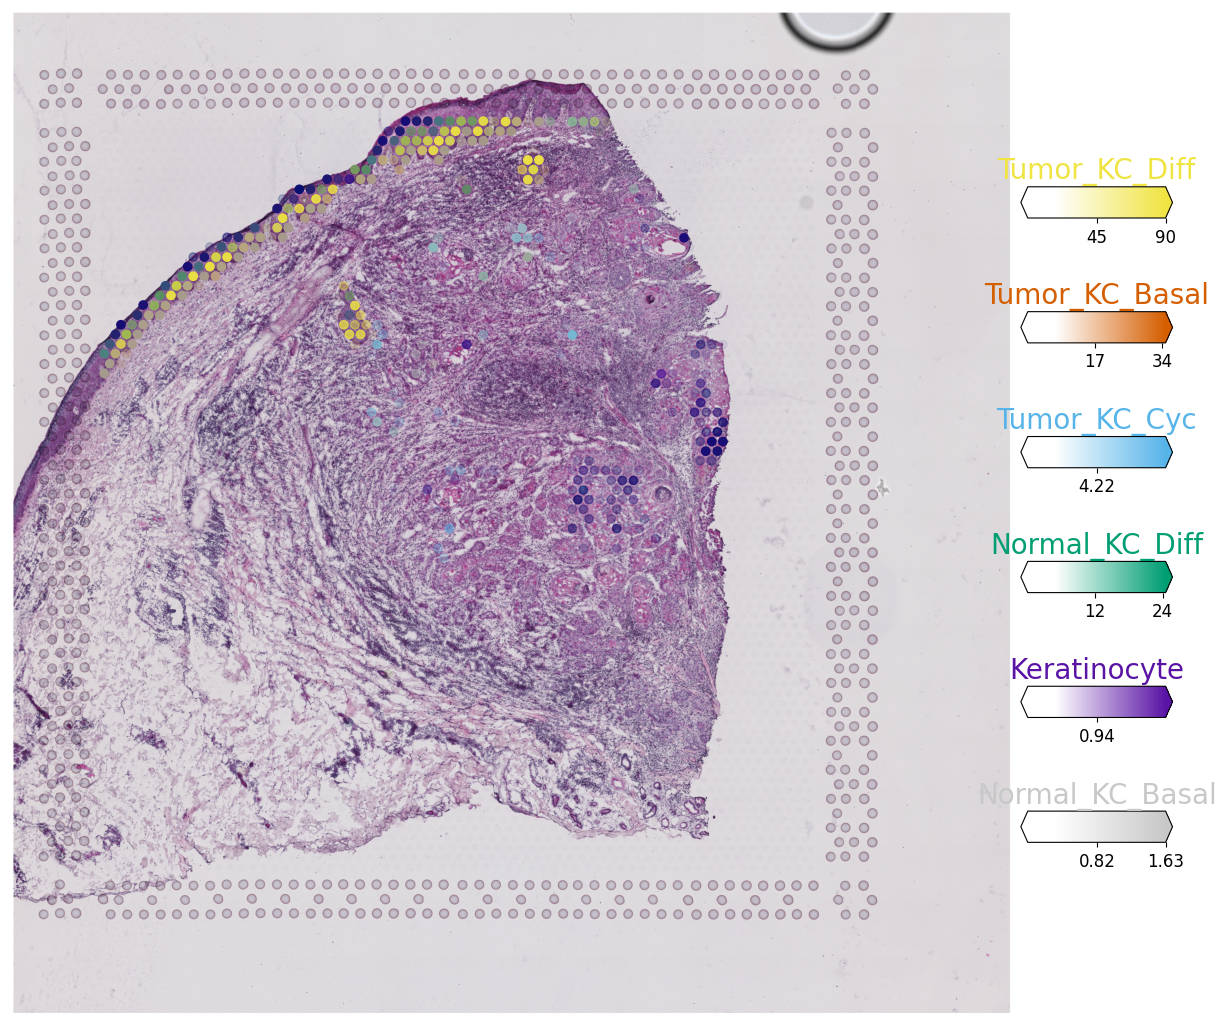

In [51]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
clust_labels = celltype_counts.index[:6]
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

#slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right'
    )
    fig.savefig(f"{run_name}/cell_abundance_map_sixCellType.pdf", bbox_inches='tight')

## Downstream analysis

In [52]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(adata_vis, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1.1)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"].astype("category")

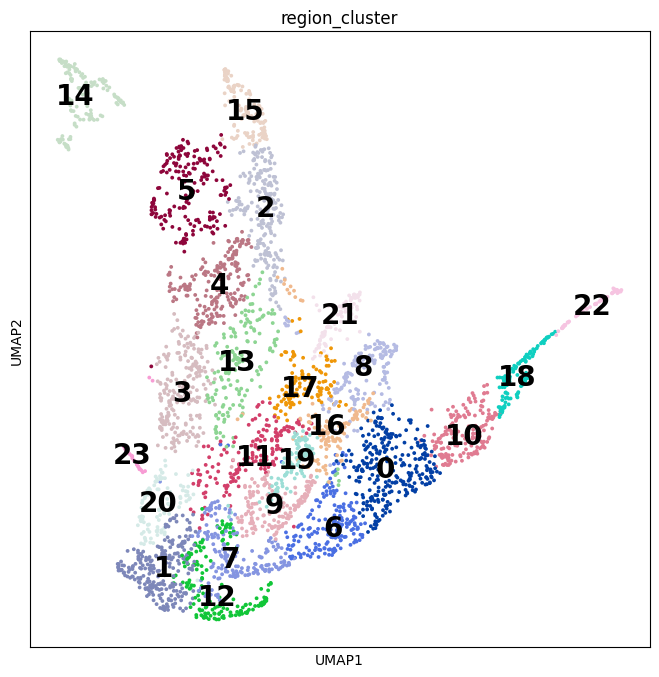

In [53]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    fig = sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20, save = sample_name + "_spatial_umap.pdf")

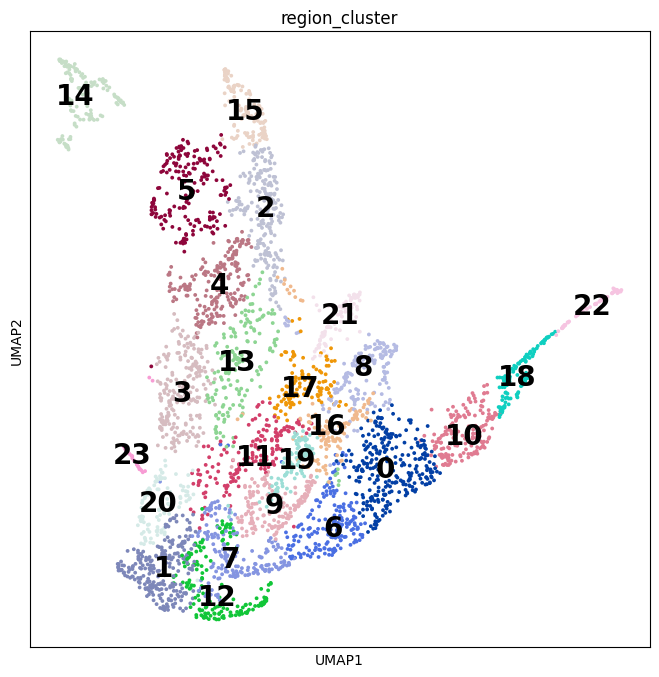

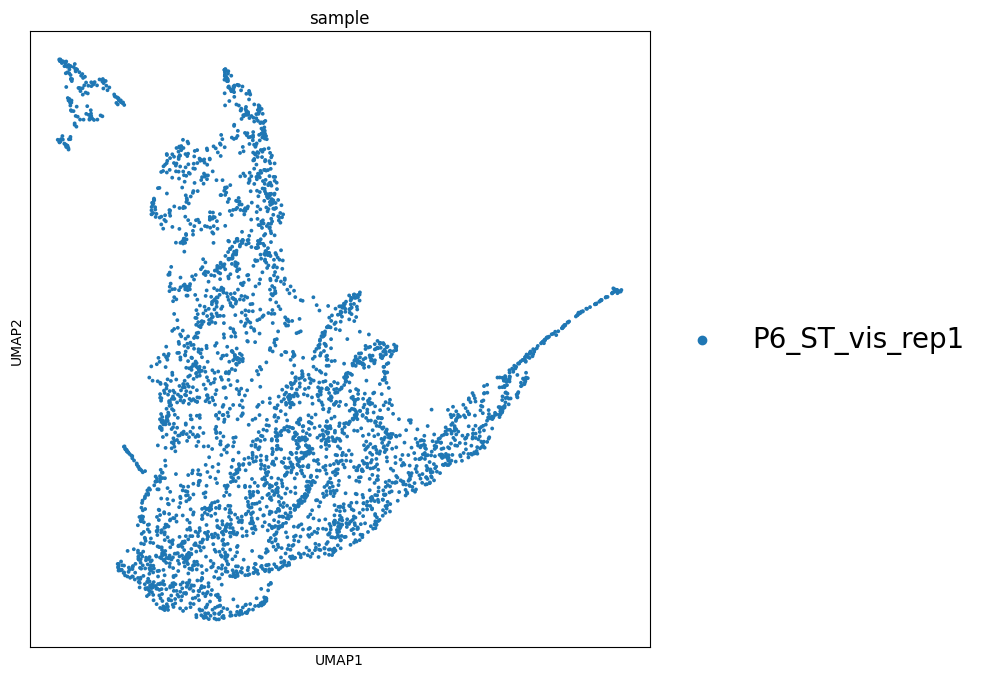

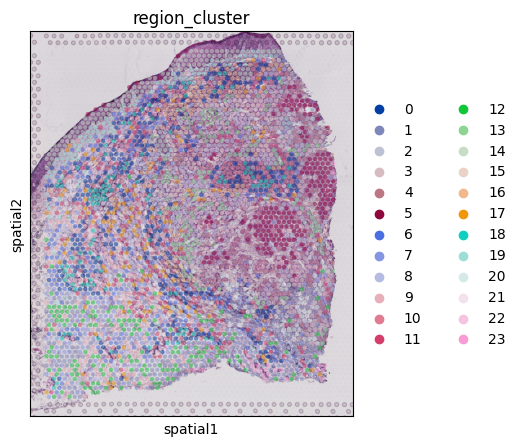

<Figure size 640x480 with 0 Axes>

In [54]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    fig = sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20, save = sample_name + "_spatial_umap.pdf")

with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    sc.pl.umap(adata_vis, color=['sample'], size=30,
               color_map = 'RdPu', ncols = 2,
               legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(adata_vis, color=['region_cluster'],
                  size=1.3, img_key='hires', alpha=0.5)
plt.savefig(f"{run_name}/region_map.pdf", bbox_inches='tight')

### Identifying cellular compartments / tissue zones using matrix factorisation (NMF)

In [55]:
from cell2location import run_colocation
res_dict, adata_vis = run_colocation(
    adata_vis,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(11, 13), # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    # the hyperparameters of NMF can be also adjusted:
    model_kwargs={'alpha': 0.01, 'init': 'random', "nmf_kwd_args": {"tol": 0.000001}},
    export_args={'path': f'{run_name}/CoLocatedComb/'}
)

### Analysis name: CoLocatedGroupsSklearnNMF_11combinations_3719locations_35factors


/data/users/linxy29/conda/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/users/linxy29/conda/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_12combinations_3719locations_35factors


/data/users/linxy29/conda/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/users/linxy29/conda/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/data/users/linxy29/conda/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/users/linxy29/conda/envs/cell2location_cuda118_torch22/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0


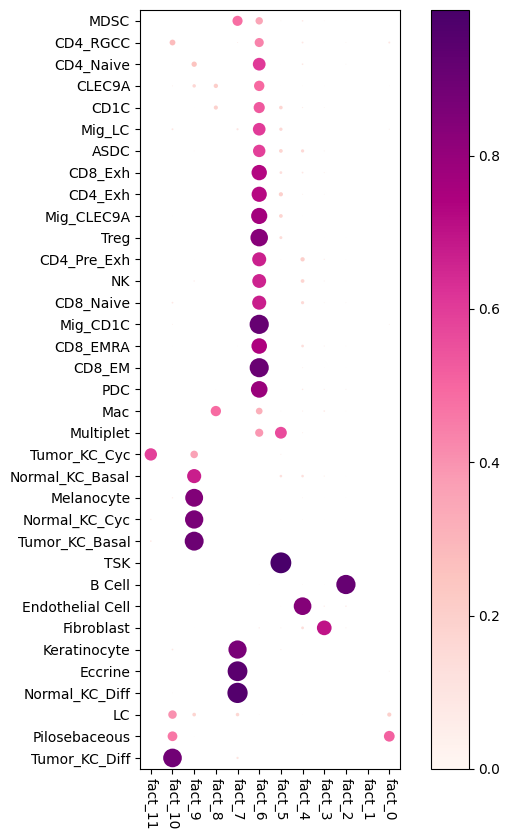

In [56]:
# Here we plot the NMF weights (Same as saved to `cell_type_fractions_heatmap`)
res_dict['n_fact12']['mod'].plot_cell_type_loadings()
plt.savefig(f"{run_name}/CoLocatedComb/CoLocatedGroupsSklearnNMF_cell_type_fractions_heatmap.pdf", bbox_inches='tight')

In [57]:
# Compute expected expression per cell type
expected_dict = mod.module.model.compute_expected_per_cell_type(
    mod.samples["post_sample_q05"], mod.adata_manager
)

# Add to anndata layers
for i, n in enumerate(mod.factor_names_):
    adata_vis.layers[n] = expected_dict['mu'][i]

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

'/home/linxy29/holab/linxy/maester/spaceclone/cSCC/cSCC_cell2location/P6_ST_vis_rep1/cell2location_map/sp.h5ad'

In [58]:
# list cell types and genes for plotting
ctypes = celltype_counts.index[:6]
genes = ['CD3D', 'CR2']

with mpl.rc_context({'axes.facecolor':  'black'}):
    # select one slide
    #slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')

    from tutorial_utils import plot_genes_per_cell_type
    plot_genes_per_cell_type(slide, genes, ctypes);

ModuleNotFoundError: No module named 'tutorial_utils'

### Advanced use

In [ ]:
# Get posterior distribution samples for specific variables
samples_w_sf = mod.sample_posterior(num_samples=1000, use_gpu=True, return_samples=True,
                                    batch_size=2020,
                                    return_sites=['w_sf', 'm_g', 'u_sf_mRNA_factors'])
# samples_w_sf['posterior_samples'] contains 1000 samples as arrays with dim=(num_samples, ...)
samples_w_sf['posterior_samples']['w_sf'].shape

In [ ]:
# Compute any quantile of the posterior distribution
medians = mod.posterior_quantile(q=0.5, batch_size=mod.adata.n_obs, use_gpu=True)

with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [5, 5]}):
    plt.scatter(medians['w_sf'].flatten(), mod.samples['post_sample_means']['w_sf'].flatten());
    plt.xlabel('median');
    plt.ylabel('mean');